In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import lightning as pl
#import datasets
import numpy as np

pl.seed_everything(89026614)

#text = datasets.load_dataset('tiny_shakespeare')["train"][0]["text"]
text = open('../../Downloads/simplebooks/simplebooks-2-raw/train.txt', 'r').read()

Global seed set to 89026614


In [5]:
device = "mps"
block_size = 256
test_size = 1500
batch_size = 36

class MyDataset(data.Dataset):
    def __init__(self, text):
        super().__init__()
        vocab = sorted(set(text))
        self.vocab = vocab
        self.stoi = { ch: i for i, ch in enumerate(vocab) }
        self.itos = { i: ch for i, ch in enumerate(vocab) }
        self.data = torch.tensor([self.stoi[ch] for ch in text], dtype=torch.long)

    def __len__(self):
        return self.data.size(0) - block_size - 1

    def __getitem__(self, i):
        end = i + block_size
        return self.data[i:end], self.data[i + 1:end + 1]

dataset = MyDataset(text)
train = data.Subset(dataset, range(0, len(dataset) - test_size))
test = data.Subset(dataset, range(len(dataset) - test_size, len(dataset)))

In [6]:
class GPT(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, num_layers=4):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Embedding(vocab_size, embed_dim),
            nn.Sequential(*[Layer(embed_dim) for _ in range(num_layers)]),
            nn.LayerNorm(embed_dim),
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, x):
        return self.lm_head(self.transformer(x))

class Layer(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * embed_dim, embed_dim),
        )
        self.register_buffer("mask", ~torch.tril(torch.ones(block_size, block_size, dtype=torch.bool)))
        t = torch.arange(-block_size, 0)
        self.register_buffer("alibi", torch.tril(torch.cat([t, t[:-1]]).unfold(0, len(t), 1).flip(0)))

    def forward(self, x):
        B, T, C = x.shape
        q, k, v = self.qkv(self.ln1(x)).chunk(3, dim=-1)
        w = q @ k.transpose(-2, -1)
        w = w + self.alibi[:T, :T]
        w.masked_fill_(self.mask[:T, :T], float("-Inf"))
        w = F.softmax(w, dim=-1)
        attn = self.proj(w @ v)

        x = x + attn
        x = x + self.mlp(self.ln2(x))
        return x

class Model(pl.LightningModule):
    def __init__(self, vocab_size, lr=0.007):
        super().__init__()
        self.lr = lr
        self.model = GPT(vocab_size)
    
    def forward(self, x, y=None):
        logits = self.model(x)
        return logits if y is None else F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

    def train_dataloader(self):
        return data.DataLoader(train, batch_size=batch_size, num_workers=0, sampler=data.RandomSampler(train, False, 6_000))

    def training_step(self, batch, batch_idx):
        return self(*batch)

    def val_dataloader(self):
        return data.DataLoader(test, batch_size=batch_size, num_workers=0)
    
    def validation_step(self, batch, batch_idx):
        loss = self(*batch)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_epoch_end(self, outs):
        with torch.no_grad():
            print(self.generate("And now", 64))

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.95, last_epoch=-1)
        return [optim], [sched]

    # inspired by https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
    @torch.no_grad()
    def generate(self, str, max_new_tokens, top_k=10):
        ids = torch.tensor([dataset.stoi[ch] for ch in str], dtype=torch.long).unsqueeze(0).to(self.device)
        for _ in range(max_new_tokens):
            out = self(ids[:, -block_size:])
            logits = out[:, -1, :]
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("Inf")
            step_res = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            # auto-regression
            ids = torch.cat((ids, step_res), dim=1)
        return "".join([dataset.itos[int(i)] for i in ids[0]])

model = Model(len(dataset.vocab))
trainer = pl.Trainer(max_epochs=40, enable_progress_bar=True, accelerator="gpu" if device == "cuda" else device)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | GPT  | 209 K 
-------------------------------
209 K     Trainable params
0         Non-trainable params
209 K     Total params
0.840     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 209/209 [00:07<00:00, 27.19it/s, loss=1.59, v_num=69, test_loss=1.760]And now?" asked that."

But you caught had ther went tearnk was hall st
Epoch 6: 100%|██████████| 209/209 [00:12<00:00, 16.57it/s, loss=1.35, v_num=69, test_loss=1.350]And now coose."

Severalow.

"And he did you, when you something them, 
Epoch 12: 100%|██████████| 209/209 [00:11<00:00, 17.57it/s, loss=1.28, v_num=69, test_loss=1.310]And now home, and she look, and the plain and make! We're going now.

T
Epoch 13: 100%|██████████| 209/209 [00:11<00:00, 17.58it/s, loss=1.26, v_num=69, test_loss=1.310]And now."

"Oh, yes, and it must take them to go to loaring or to harm.
Epoch 17: 100%|██████████| 209/209 [00:11<00:00, 17.93it/s, loss=1.24, v_num=69, test_loss=1.280]And now than the chief."

"Then they looked at his pipe in, into them o
Epoch 19: 100%|██████████| 209/209 [00:13<00:00, 15.66it/s, loss=1.23, v_num=69, test_loss=1.280]And now they could be would not lose up anything that took t

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 209/209 [00:12<00:00, 16.42it/s, loss=1.17, v_num=69, test_loss=1.190]


Epoch 4: 100%|██████████| 209/209 [09:04<00:00,  2.61s/it, loss=1.4, v_num=68, test_loss=1.470]


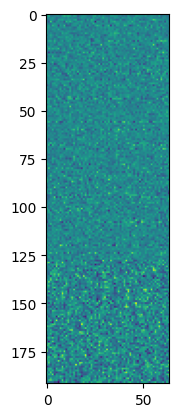

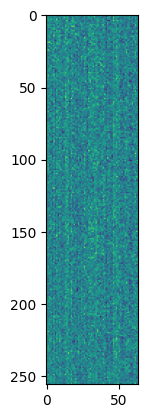

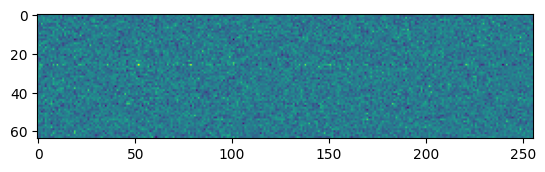

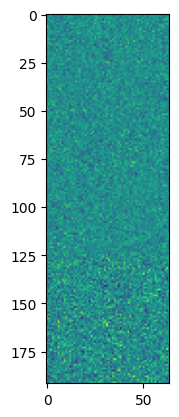

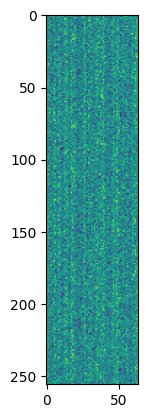

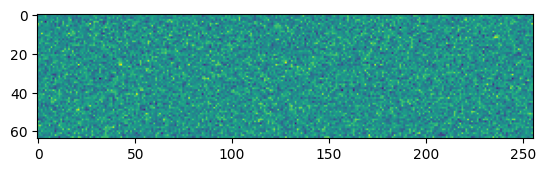

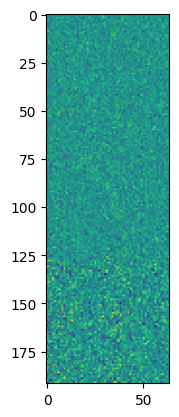

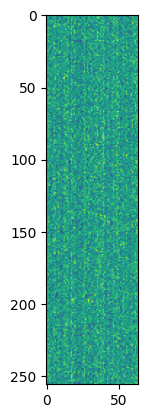

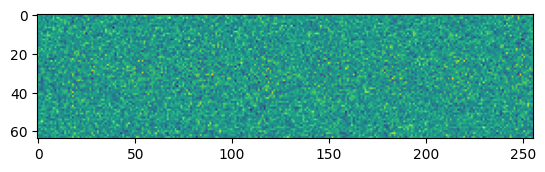

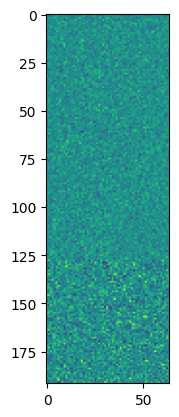

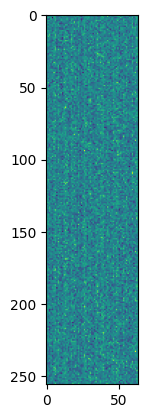

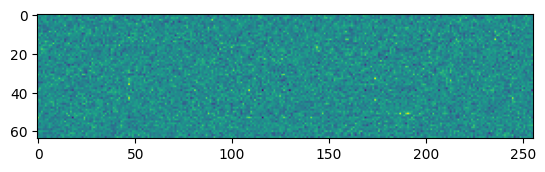

In [7]:
from matplotlib import pyplot as plt
for b in model.model.transformer[1]:
    plt.figure()
    plt.imshow(b.qkv.weight.detach())
    plt.figure()
    plt.imshow(b.mlp[0].weight.detach())
    plt.figure()
    plt.imshow(b.mlp[2].weight.detach())

In [8]:
print(model.generate("O God, O God!", 1024))

O God, O God!" cried.

"I must get all about who such for me, I'll soon within the country. But!" cried Mrs. Story in the decire, she had lowered bitten such a perch to sit down again shovel somebody? Whood is she did not hand they and I shall and learn to half folks with a chance.

"We will you?" she asked the west off of the champions and these shore. A third picket up?"

"You wouldn't get those place. And soon also aside! How can we at the old man in town here. This will.

He was to forget to the door, and began too tricks, and he had not some down frighting passt them in overalls the one of the hare, and her friends.

Altartled would break a land was the funny and stick the charge with her surnt that he wasn't short of a steady in the ground, but I thought so his brothing that it since here. Henry, and you are with their boat and went to him.

So the same big cage.




Trusoting this on her aim?" she asked.

"We get in his crew, and we had seen a complet. HAnd where I don't meet hi